In [2]:
import os
import scanpy as sc
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from matplotlib.colors import TwoSlopeNorm
import matplotlib as mpl
import gseapy as gp
import seaborn as sns

In [3]:
figpath = '/stanley/WangLab/kamal/figures/projects/manifesto/duality_tonsil_fh/'
os.makedirs(figpath, exist_ok=True)
dpi = 500

# Load

In [5]:
adata = sc.read_h5ad('/stanley/WangLab/kamal/data/technologies/xenium/tonsil_fh/filtered/adata_juxtacrine_dual.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 1349474 × 377
    obs: 'transcript_counts', 'n_counts'
    uns: 'log1p'
    obsm: 'spatial'
    layers: 'juxtacrine_dual'

In [7]:
filter_key = 'juxtacrine_dual'
max_mag = 2

# Scale
sc.pp.scale(adata, layer=filter_key)

# Clip
X = adata.layers[filter_key]
X[X > max_mag] = max_mag
X[X < -max_mag] = -max_mag

In [8]:
# Check loading
filepath = '/stanley/WangLab/kamal/code/projects/manifesto/figures/tonsil_fh_regions.npy'
regions = np.load(filepath, allow_pickle=True)
adata.obs['region'] = regions

In [9]:
# Set figure size
width = adata.obsm['spatial'][:,0].ptp()
height = adata.obsm['spatial'][:,1].ptp()
set_width = 10
fignorm = set_width / width
sc.set_figure_params(figsize=(set_width, height*fignorm))
figsize=(set_width, height*fignorm)

# Clustering

## Cluster

In [10]:
def embed(adata, region, n_comps, filter_key):

    adata_region = adata[adata.obs['region']==region]
    adata_notregion = adata[adata.obs['region']!=region]

    X = adata_region.layers[filter_key]
    X -= X.mean(axis=0)
    A = X.T @ X

    X_ = adata_notregion.layers[filter_key]
    X_ -= X_.mean(axis=0)
    B = X_.T @ X_

    w,V = eigh(A,B)
    w = w[::-1]
    V = V[:,::-1]

    V = V[:,:n_comps]
    adata.obsm[f'X_pca_{filter_key}'] = adata.layers[filter_key] @ V
    adata.varm[f'X_pca_{filter_key}'] = V
    adata.uns[f'comp_var_{filter_key}'] = w

    return V

In [11]:
n_comps = 3
region = '3'

In [12]:
V = embed(adata, region, n_comps, filter_key)

In [13]:
n_regions = 3
kmeans = KMeans(n_clusters=n_regions, random_state=0)
kmeans.fit(adata.obsm[f'X_pca_{filter_key}'])
adata.obs['region'] = kmeans.labels_.astype(str)

/stanley/WangLab/kamal/envs/xax/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


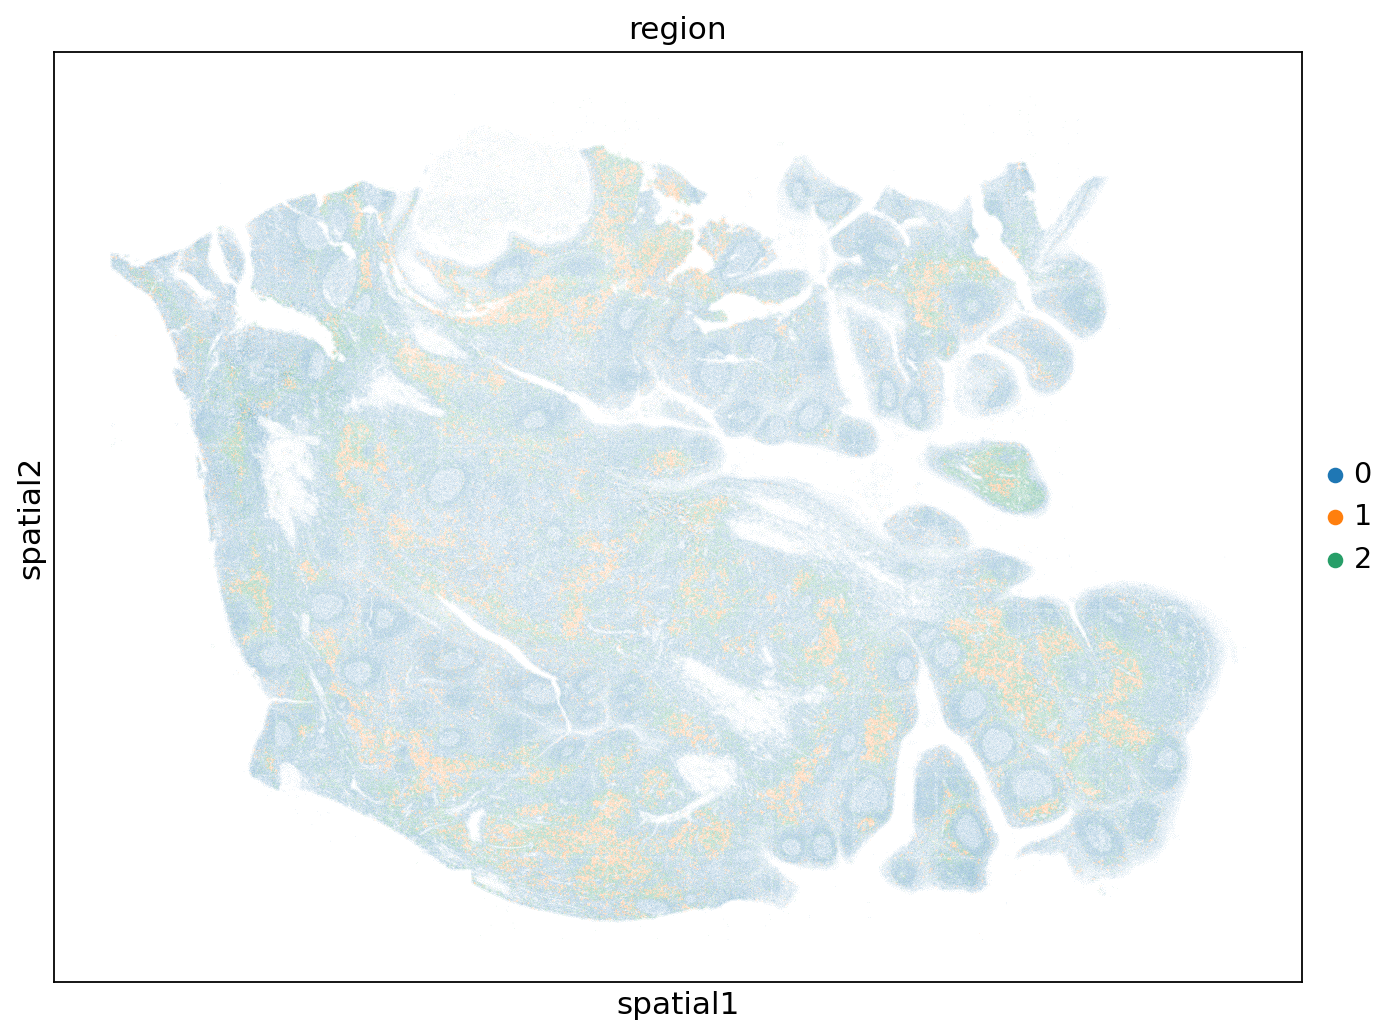

In [23]:
sc.pl.embedding(
    adata,
    basis='spatial',
    color='region',
)

In [24]:
adata.obs['is_ixn'] = adata.obs['region'] == '1'

## Plot zoom

In [25]:
# Set zoom dims
width = adata.obsm['spatial'][:,0].ptp()
height = adata.obsm['spatial'][:,1].ptp()
zoom_width = height/9
zoom_height = zoom_width * 0.6

In [26]:
zoom_x = 7200
zoom_y = 1850

In [27]:
zdata = adata[adata.obsm['spatial'][:,0]>zoom_x]
zdata = zdata[zdata.obsm['spatial'][:,0]<zoom_x+zoom_width]
zdata = zdata[zdata.obsm['spatial'][:,1]>zoom_y]
zdata = zdata[zdata.obsm['spatial'][:,1]<zoom_y+zoom_height]

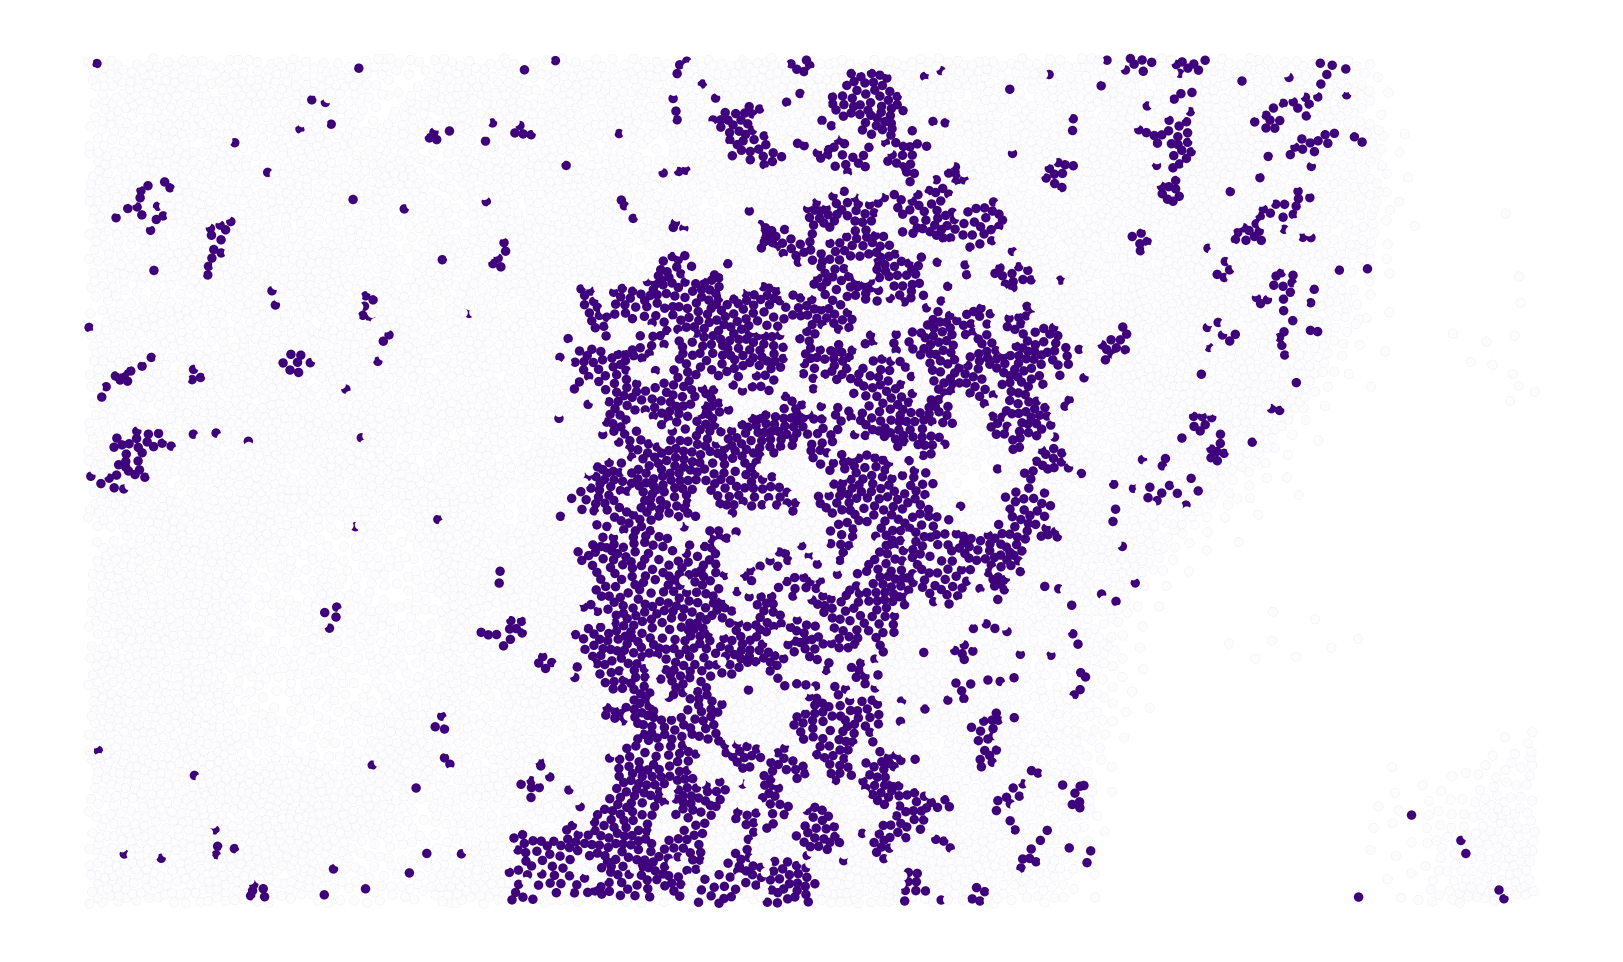

In [28]:
points = zdata.obsm['spatial']
plt.figure(figsize=(height*fignorm*(zoom_width/zoom_height), height*fignorm))
plt.scatter(
    points[:,0],
    points[:,1],
    edgecolor='k',
    linewidth=0.01,
    s=18,
    c=zdata.obs['is_ixn'],
    cmap='Purples'
)
plt.axis('off')
filename = os.path.join(figpath, f'duality_zoom.png')
plt.savefig(filename, dpi=dpi)
plt.show()

# Plot markers

In [29]:
sc.tl.rank_genes_groups(adata, groupby='region', layer=filter_key)
sc.tl.dendrogram(adata, groupby='region', use_rep=f'X_pca_{filter_key}')

/home/unix/kmaher/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/unix/kmaher/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/unix/kmaher/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


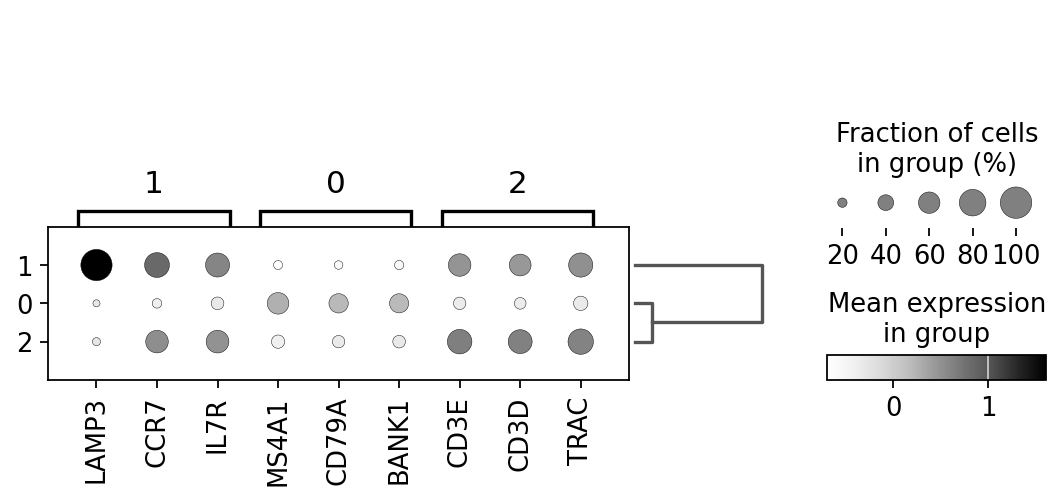

In [30]:
fig = plt.figure(figsize=(8,3))
ax = plt.gca()
sc.pl.rank_genes_groups_dotplot(adata, groupby='region', n_genes=3, ax=ax, cmap='Greys', layer=filter_key)
figname = 'region_markers.png'
savepath = os.path.join(figpath, figname)
fig.savefig(savepath, dpi=dpi, bbox_inches='tight')